# Prithvi WxC Downscaling using ECCC data: Model Fine Tuning and Inference

This notebook is a walk through to use the `Prithvi` downscaling model to generate inferences using TerraTorch with the `ECCC data` for downscaling `v10` -- VVSN and `u10` -- UUWE wind components

We show how to initalize the model, load weights, and use the model for inference using TerraTorch

In [1]:
!pip install -q git+https://github.com/IBM/terratorch.git
!pip install -q git+https://github.com/NASA-IMPACT/Prithvi-WxC.git
!pip install -q git+https://github.com/IBM/granite-wxc.git

In [2]:
import logging
import warnings
logging.disable(logging.CRITICAL)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import torch
import numpy as np
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from terratorch.models.wxc_model_factory import WxCModelFactory
from terratorch.tasks.eccc_downscaling_task import ECCCTask, CheckpointCallback
from terratorch.datamodules.eccc import ECCCDataModule

from granitewxc.utils.config import get_config
from granitewxc.utils.plot import plot_sample, plot_eccc_results, plot_residual_and_power_spectrum

Configure the backends and torch states, including setting the seeds for the RNGs

In [4]:
torch.jit.enable_onednn_fusion(True)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)

It is possible to use a cpu or gpu/s to generate inferences. Based on avaiablity of a cuda:gpu we set the device the model uses

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Model Initialization

The `ECCCTask` class is task module designed to manage the training, validation, and testing processes for models built on the ECCC data


The model is built using `yaml` configuration files

To ensure compatibility with the provided weights during inference, the model configuration should remain consistent with the definitions in the configuration file

We provide **2** different model architectures `UNET` and `CONV`, where both include:

1. **Patch Embedding:** Extracts shallow features from the input data
2. **Feature Extraction:** Utilizes the `Prithvi` backbone to extract features.

The key difference between the two is that the UNET-like version incorporates **static high-resolution data** into the model

In this notebook, we are using the UNET version

To switch to the `CONV` model, change the configuration to `./examples/confs/eccc_downscaling_conv.yaml`

In [6]:
config_path = './examples/confs/eccc_downscaling_unet.yaml'
config = get_config(config_path)
task = ECCCTask(WxCModelFactory(), model_args=config)

Creating the model.
--> model has 254,648,712 params.
Loading pre-trained model weights ./experiments/pretrained/prithvi.wxc.2300m.v1.pt...


# Datamodule

A datamodule is a module that organizes and manages the preparation of training, validation, and test datasets, along with any associated data transformations

In [7]:
datamodule = ECCCDataModule(config)

You can download the HRDPS and GDPS datasets, which correspond to high-resolution and low-resolution data respectively, from the following links:

- HRDPS (High-Resolution Deterministic Prediction System): [Download Here](https://hpfx.collab.science.gc.ca/~snow000/hrdps_domain/hrdps/)

- GDPS (Global Deterministic Prediction System): [Download Here](https://hpfx.collab.science.gc.ca/~snow000/hrdps_domain/gdps_regridded/)

- Static Data: [Download Here](https://hpfx.collab.science.gc.ca/~snow000/hrdps_domain/geophy.nc)

Obs.: Note that the geophysical fields in the static data are slightly larger than those in the HRDPS data, so you will need to perform appropriate cropping to match the files

### Setup data indexes

The data is organized in `JSON` files, mapping unique indices (as string keys) to pairs of file paths. Each index key points to an array containing two strings:

````
{
  "index": ["GDPS data path", "HRDPS data path"],
  ...
}
````

Each entry represents a paired dataset where the GDPS and HRDPS files correspond to the same timestamp and region. The data files are stored in **NetCDF** format (`.nc`)

We provide an `index generator` to automatically create your JSON index file, and a `scalar generator` to normalize the data before feeding it into the model

You can find these scripts here: [Scripts](https://github.com/IBM/granite-wxc/tree/main/examples/eccc_downscaling)

**Important:** Scalars statistics must be computed **exclusively** using your **training data**!


# Training

The ECCC data corresponds to the entire Canadian region

For training, we adopt a strategy that randomly crops the data into patches of fixed width and height, which are then used to train the model. For inference we will use the entire region...

You can adjust the size and number of crops in the configuration file

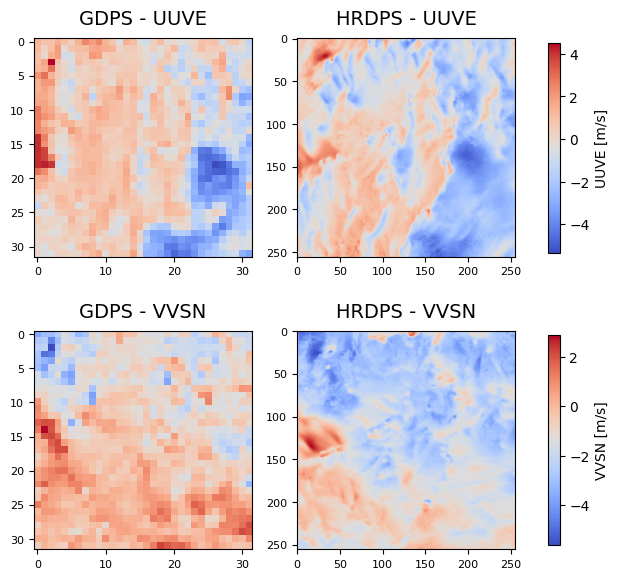

In [8]:
datamodule.setup(stage='fit')
train_dl = datamodule.train_dataloader()
plot_sample(next(iter(train_dl)))

Pytorch Lightning trainers encapsulate the model, loss function, optimizer, and training hyperparameters

They build on the model factory and are able to take any. To use a task with a model not supported by a currently existing model factory, simply create your own model factory!

Let's create a Trainer

In [9]:
logger = TensorBoardLogger("logs", name="eccc", log_graph=False)
checkpoint_callback = CheckpointCallback(config, save_every_n_epochs=2)

trainer = Trainer(
    max_epochs=3,
    check_val_every_n_epoch=1,
    log_every_n_steps=config.data.n_random_windows,
    logger=logger,
    callbacks=[checkpoint_callback],
    devices=1,
    precision="16-mixed",
)

In [10]:
datamodule.setup(stage='val')
trainer.fit(model=task, datamodule=datamodule)

Sanity Checking: |                                                            | 0/? [00:00<?, ?it/s]

Training: |                                                                   | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]


--> Saved checkpoint: ./experiments/pretrained/checkpoint_2.pt


##### Analyze training in tensorboard

In [11]:
# !tensorboard --logdir logs/ --port 9010  # add --host $(hostname -f) for clusters

# Evaluation

For evaluation, we will use the entire Canadian region, an (1280, 2528) image

In [12]:
datamodule.setup(stage='test')
test_metrics = trainer.test(model=task, datamodule=datamodule)

Testing: |                                                                    | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_LSD          │    0.28612449765205383    │
│         test_MAE          │     0.708888590335846     │
│        test_MSSIM         │    0.7328707575798035     │
│         test_loss         │    0.9978652000427246     │
└───────────────────────────┴───────────────────────────┘

### Model Inference

In [13]:
datamodule.setup(stage='predict')
results = trainer.predict(model=task, datamodule=datamodule, return_predictions=True)

Predicting: |                                                                 | 0/? [00:00<?, ?it/s]

In [14]:
idx = 0 # select a sample
pred_dl = datamodule.predict_dataloader()
batch = next(iter(pred_dl))

inputs = batch["x"][idx].cpu().numpy()
targets = batch["y"][idx].cpu().numpy()
result = results[idx].output.squeeze().cpu().numpy()
residuals = targets - result

In [15]:
print(f"Input shape:  {inputs.shape}")
print(f"Target shape: {targets.shape}")
print(f"Result shape: {result.shape}")

Input shape:  (57, 160, 316)
Target shape: (2, 1280, 2528)
Result shape: (2, 1280, 2528)


### Plotting 

In [16]:
from itertools import product

# getting variable indexes
output_vars = [*config.data.output_vars]
input_vars = [*config.data.input_surface_vars, 
              *product(config.data.vertical_pres_vars, config.data.input_level_pres),
              *product(config.data.vertical_level1_vars, config.data.input_level1 ),
              *product(config.data.vertical_level2_vars, config.data.input_level2),
              *config.data.other
             ]

coarsening_factor = targets.shape[-1] / inputs.shape[-1] 

var_name = "UUWE" # UUWE or VVSN
var_unit = "m/s" 
f"Downscaling '{var_name}' at  by {coarsening_factor}x"

"Downscaling 'UUWE' at  by 8.0x"

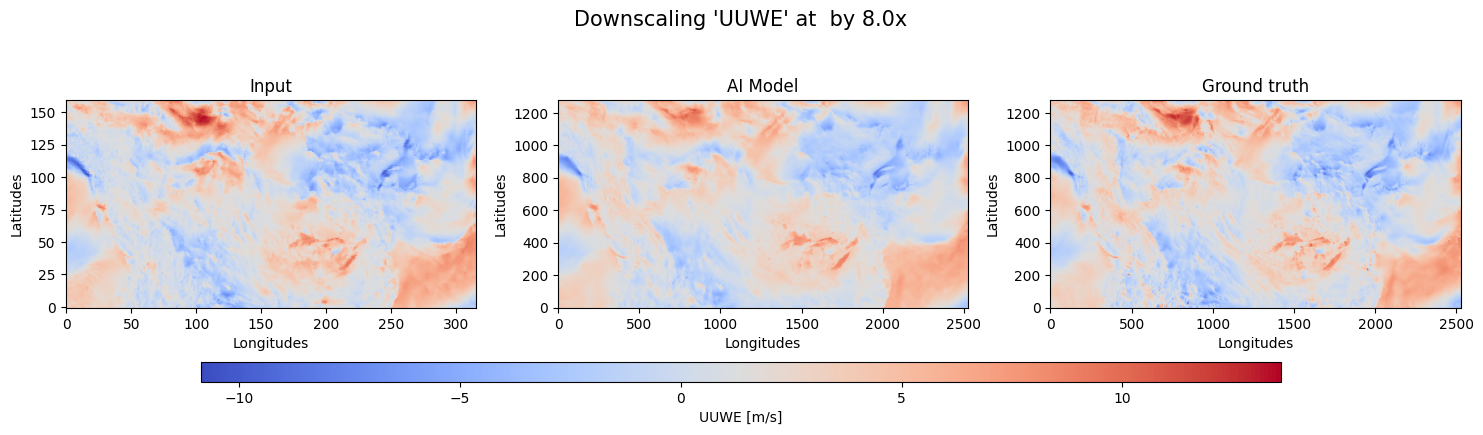

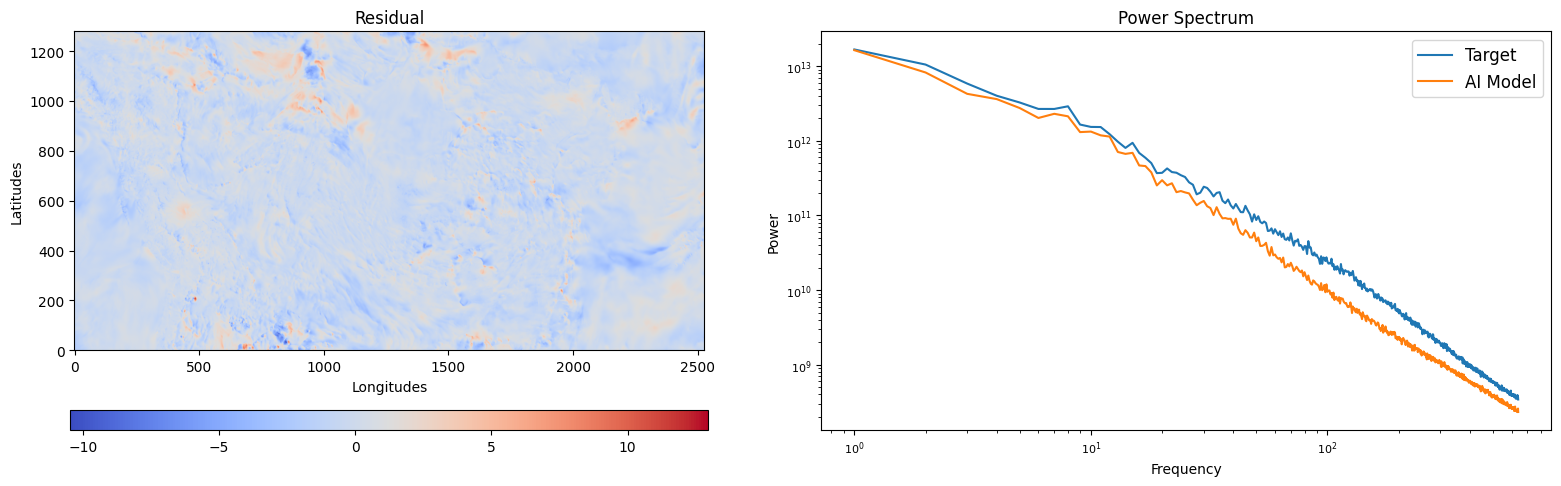

In [17]:
output_var = output_vars.index(var_name)
input_var = input_vars.index(var_name)

plot_val_kwargs = dict(
    cmap='coolwarm',
    vmin = min(np.min(inputs[input_var]), np.min(targets[output_var]), np.min(result[output_var])),
    vmax = max(np.max(inputs[input_var]), np.max(targets[output_var]), np.max(result[output_var])),
    var_name_title=var_name,
    var_unit=var_unit
    )

plot_eccc_results(
    [inputs[1], result[0], targets[0]],
    ['Input', 'AI Model', 'Ground truth'],
    title=f"Downscaling '{var_name}' at  by {coarsening_factor}x",
    cbar_title=f"{var_name} [{var_unit}]",
    **plot_val_kwargs
)

plot_residual_and_power_spectrum(residuals[output_var], targets[output_var], result[output_var], kwargs={'vmin': -2, 'vmax': 2})